# Checking the MNIST dataset from TFDS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
# from sklearn.datasets import load_digits

import tensorflow as tf
# import tensorflow_datasets as tfds

In [2]:
tf.__version__

'2.5.0'

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# data stored in C:\Users\user\tensorflow_datasets
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

NameError: name 'tfds' is not defined

In [5]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\user\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [6]:
len(ds_train), len(ds_test)

(60000, 10000)

In [7]:
ds_train = list(ds_train.take(10000).as_numpy_iterator())
ds_test = list(ds_test.take(1500).as_numpy_iterator())
len(ds_train), len(ds_test)

(10000, 1500)

In [8]:
X_train, y_train = zip(*ds_train)
X_test, y_test = zip(*ds_test)

In [9]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
X_train.shape, y_train.shape

((10000, 28, 28, 1), (10000,))

4


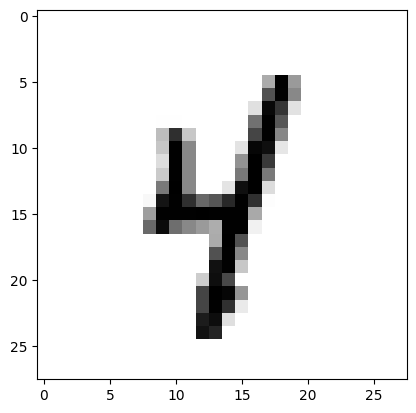

In [11]:
print(y_train[0])
plt.imshow(X_train[0], cmap='gray_r')
plt.show()

In [12]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([1019, 1095,  996, 1002,  971,  896,  994, 1079,  964,  984],
       dtype=int64))

In [13]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([158, 167, 169, 148, 130, 131, 150, 166, 148, 133], dtype=int64))

In [14]:
del X_train, y_train, X_test, y_test

In [15]:
import gc
gc.collect()

4092

In [16]:
%who

cv2	 ds_info	 ds_test	 ds_train	 gc	 load_digits	 np	 plt	 tf	 
tfds	 


# Training

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

In [18]:
ds_train = ds_train.take(10000)
ds_test = ds_test.take(1500)

In [19]:
len(ds_train), len(ds_test)

(10000, 1500)

In [20]:
for x, y in ds_train.take(1):
    print(x.shape)
    print(y)

(28, 28, 1)
tf.Tensor(4, shape=(), dtype=int64)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 10
BATCH_SIZE = 200

In [22]:
def one_hot_label(image, label):
    """One-hot encode the labels."""
    label = tf.one_hot(label, 10)
    return image, label

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [23]:
ds_train = (ds_train
            .map(normalize_img,
                 num_parallel_calls=AUTOTUNE)
            .map(one_hot_label,
                 num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(len(ds_train))
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

In [24]:
ds_test = (ds_test
            .map(normalize_img,
                 num_parallel_calls=AUTOTUNE)
            .map(one_hot_label,
                 num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

In [25]:
for x, y in ds_train.take(1):
    print(x.shape)
    print(y)

(200, 28, 28, 1)
tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(200, 10), dtype=float32)


In [26]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, 3, strides=1, padding='valid',
                           dilation_rate=(1, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(
    ## the book uses Adadelta, but default Adadelta trains too slow
    # optimizer=tf.keras.optimizers.Adadelta(),
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    metrics=["accuracy"],
)

history = model.fit(
    ds_train,
    epochs=10,
)

Epoch 1/10
50/50 [==============================] - 2s 6ms/step - loss: 0.6704 - accuracy: 0.8080
Epoch 2/10
50/50 [==============================] - 0s 6ms/step - loss: 0.2777 - accuracy: 0.9169
Epoch 3/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2086 - accuracy: 0.9383
Epoch 4/10
50/50 [==============================] - 0s 6ms/step - loss: 0.1592 - accuracy: 0.9547
Epoch 5/10
50/50 [==============================] - 0s 6ms/step - loss: 0.1295 - accuracy: 0.9652
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0998 - accuracy: 0.9726
Epoch 7/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0852 - accuracy: 0.9777
Epoch 8/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0675 - accuracy: 0.9833
Epoch 9/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0580 - accuracy: 0.9853
Epoch 10/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.9901


In [28]:
(loss, accuracy) = model.evaluate(ds_test)
accuracy

8/8 [==============================] - 0s 26ms/step - loss: 0.0990 - accuracy: 0.9713


0.9713333249092102

# Results Record

-> Not normalized

Epoch 10/10

79/79 [==============================] - 0s 3ms/step - loss: 0.2059 - sparse_categorical_accuracy: 0.9826 - val_loss: 2.3619 - val_sparse_categorical_accuracy: 0.9293

Epoch 10/10

79/79 [==============================] - 0s 3ms/step - loss: 0.2166 - sparse_categorical_accuracy: 0.9830 - val_loss: 2.2622 - val_sparse_categorical_accuracy: 0.9327

-> Normalized

Epoch 10/10
79/79 [==============================] - 0s 3ms/step - loss: 0.0973 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.1801 - val_sparse_categorical_accuracy: 0.9473

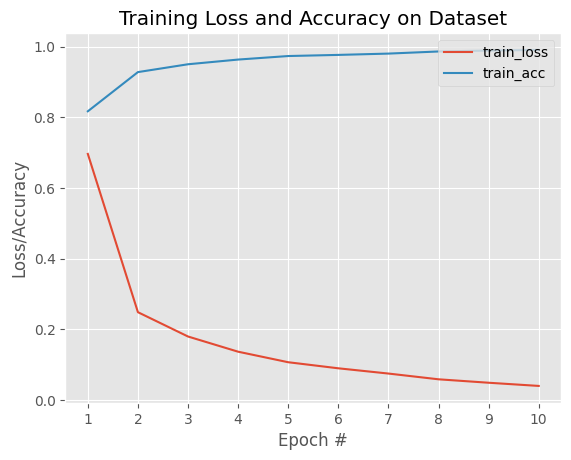

In [31]:
N = EPOCHS
plt.style.use("ggplot")
plt.xticks(np.arange(1, N + 1))
plt.plot(np.arange(1, N + 1), history.history["loss"], label="train_loss")
plt.plot(np.arange(1, N + 1), history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

# Using downloaded MNIST images obtained from KNIME

In [8]:
import os

BASE_DIR = r"T:\New Download Folder\SHRDC Data\KNIME Example Data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")
print(os.path.exists(TEST_DIR))

TRAIN_GT_PATH = os.path.join(TRAIN_DIR, "gt.txt")
TEST_GT_PATH = os.path.join(TEST_DIR, "gt.txt")
print(os.path.exists(TRAIN_GT_PATH))

True
True


In [9]:
with open(TRAIN_GT_PATH, mode='r') as f:
    y_train = f.read().strip().split("\n")

with open(TEST_GT_PATH, mode='r') as f:
    y_test = f.read().strip().split("\n")

In [10]:
import numpy as np

y_train, y_test = np.array(y_train, dtype=np.int32), np.array(y_test, dtype=np.int32)

In [11]:
y_train.shape, y_test.shape

((10000,), (1500,))

In [12]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1001, 1127,  991, 1032,  980,  863, 1014, 1070,  944,  978],
       dtype=int64))

In [13]:
def get_img_cnt(img_path):
    img_cnt = img_path.split("Row")[-1].split(".")[0]
    return int(img_cnt)

In [14]:
get_img_cnt('T:\\New Download Folder\\SHRDC Data\\KNIME Example Data\\train\\images\\Row9997.png')

9997

In [15]:
from imutils.paths import list_images

X_train = np.array(sorted(list(list_images(TRAIN_DIR)), key=get_img_cnt))
X_test = np.array(sorted(list(list_images(TEST_DIR)), key=get_img_cnt))

In [16]:
X_train.shape, X_test.shape

((10000,), (1500,))

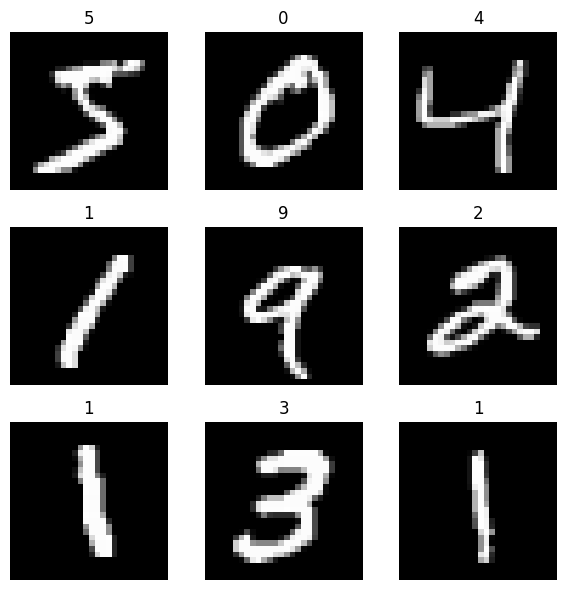

In [17]:
plt.figure(figsize=(6, 6))
for i, (x, y) in enumerate(zip(X_train, y_train)):
    ax = plt.subplot(3, 3, i+1)
    img = plt.imread(x)
    plt.imshow(img, cmap='gray')
    plt.title(y)
    plt.axis(False)
    if i + 1 == 9:
        break
plt.tight_layout()
plt.show()

# Preparing tf.data Dataset

In [18]:
EPOCHS = 10
BATCH_SIZE = 200

In [19]:
import tensorflow as tf

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [20]:
def preprocess_data(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, 10)
    return image, label

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.map(preprocess_data, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(preprocess_data, num_parallel_calls=AUTOTUNE)

(28, 28, 1)
(10,)


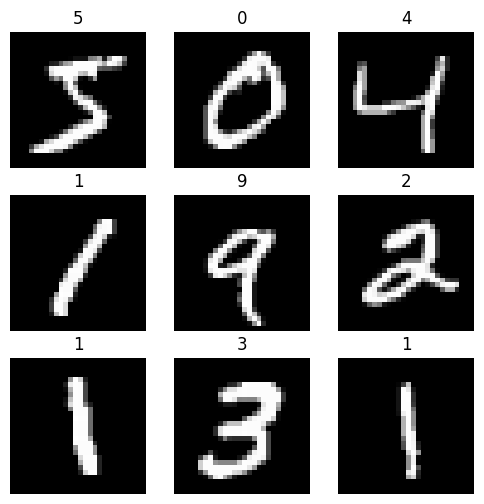

In [22]:
## Showing a batch of images with labels

plt.figure(figsize=(6, 6))
i = 0
for img, label in ds_train.take(9):
    # with 3 rows and 3 columns
    ax = plt.subplot(3, 3, i+1)
    # show in grayscale
    plt.imshow(img, cmap='gray')
    # add the label name on top
    plt.title(np.argmax(label))
    plt.axis('off')
    i += 1
print(img.shape)
print(label.shape)
plt.show()

In [23]:
ds_train = (ds_train
            .cache()
            .shuffle(len(ds_train), seed=42)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

ds_test = (ds_test
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

(200, 28, 28, 1)
(200, 10)


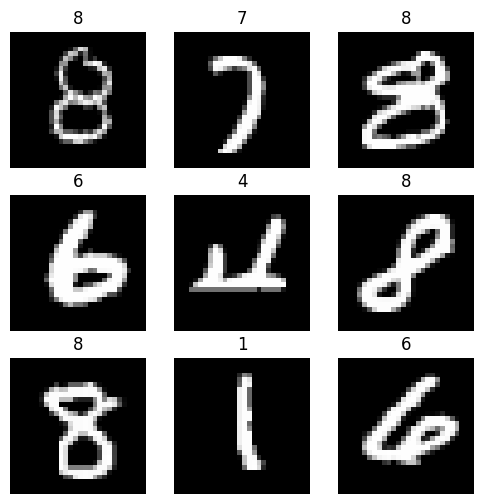

In [21]:
## Showing a batch of images with labels

plt.figure(figsize=(6, 6))
i = 0
for img, label in ds_train.take(1):
    while i < 9:
        # with 3 rows and 3 columns
        ax = plt.subplot(3, 3, i+1)
        # show in grayscale
        plt.imshow(img[i], cmap='gray')
        # add the label name on top
        plt.title(np.argmax(label[i]))
        plt.axis('off')
        i += 1
print(img.shape)
print(label.shape)
plt.show()

# Model

In [48]:
def create_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, 3, strides=1, padding='valid',
                               dilation_rate=(1, 1), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


# Adadelta

In [52]:
model_adadelta = create_model()

model_adadelta.compile(
    ## the book uses Adadelta, but default Adadelta trains too slow
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1.0e-8),
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model_adadelta.fit(
    ds_train,
    epochs=EPOCHS,
)

Epoch 1/10
50/50 [==============================] - 1s 6ms/step - loss: 1.0502 - accuracy: 0.7453
Epoch 2/10
50/50 [==============================] - 0s 6ms/step - loss: 0.3710 - accuracy: 0.8923
Epoch 3/10
50/50 [==============================] - 0s 6ms/step - loss: 0.2696 - accuracy: 0.9232
Epoch 4/10
50/50 [==============================] - 0s 6ms/step - loss: 0.2202 - accuracy: 0.9363
Epoch 5/10
50/50 [==============================] - 0s 6ms/step - loss: 0.1844 - accuracy: 0.9480
Epoch 6/10
50/50 [==============================] - 0s 6ms/step - loss: 0.1566 - accuracy: 0.9567
Epoch 7/10
50/50 [==============================] - 0s 6ms/step - loss: 0.1368 - accuracy: 0.9617
Epoch 8/10
50/50 [==============================] - 0s 6ms/step - loss: 0.1170 - accuracy: 0.9686
Epoch 9/10
50/50 [==============================] - 0s 6ms/step - loss: 0.1030 - accuracy: 0.9695
Epoch 10/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0908 - accuracy: 0.9747


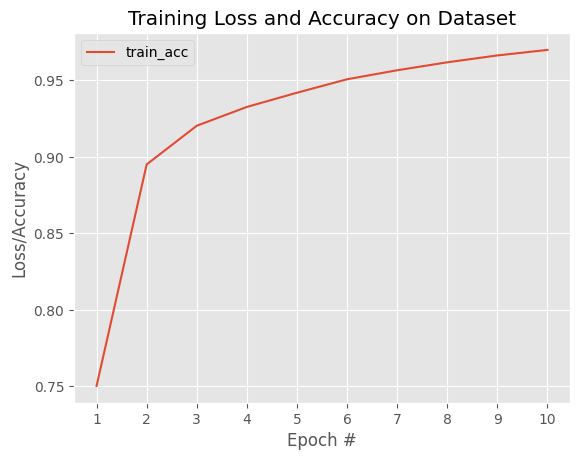

In [28]:
N = EPOCHS
plt.style.use("ggplot")
plt.xticks(np.arange(1, N + 1))
# plt.plot(np.arange(1, N + 1), history.history["loss"], label="train_loss")
plt.plot(np.arange(1, N + 1), history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [26]:
(loss, accuracy) = model_adadelta.evaluate(ds_test)
accuracy

8/8 [==============================] - 0s 31ms/step - loss: 0.1825 - accuracy: 0.9427


0.9426666498184204

![Adadelta Train Result.jpeg](results/Adadelta-Train-Result.jpeg)

In [173]:
model_save_path = os.path.join("models", "python_adadelta")
tf.saved_model.save(model_adadelta, model_save_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models\python_adadelta\assets


In [174]:
model_save_path = os.path.join("models", "python_adadelta2")
tf.keras.models.save_model(model_adadelta, model_save_path)

INFO:tensorflow:Assets written to: models\python_adadelta2\assets


In [188]:
model_adadelta = tf.keras.models.load_model(os.path.join("models", "python_adadelta2"))

In [189]:
%%time
preds = model_adadelta.predict(ds_test)
preds.shape

Wall time: 53 ms


(1500, 10)

In [190]:
preds = np.argmax(preds, axis=-1)
preds.shape

(1500,)

In [191]:
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true.shape

(1500, 10)

In [192]:
y_true = np.argmax(y_true, axis=-1)
y_true.shape

(1500,)

In [193]:
total_correct = np.sum(np.where(preds == y_true, 1, 0))
total_incorrect = len(y_true) - total_correct
acc = total_correct / len(y_true) * 100
error = 100 - acc

In [194]:
adadelta_py = {"Training accuracy": 97.10, "Validation accuracy": acc,
               "Correct classified": total_correct, "Wrong classified": total_incorrect, "Error": error
}
adadelta_py

{'Training accuracy': 97.1,
 'Validation accuracy': 95.0,
 'Correct classified': 1425,
 'Wrong classified': 75,
 'Error': 5.0}

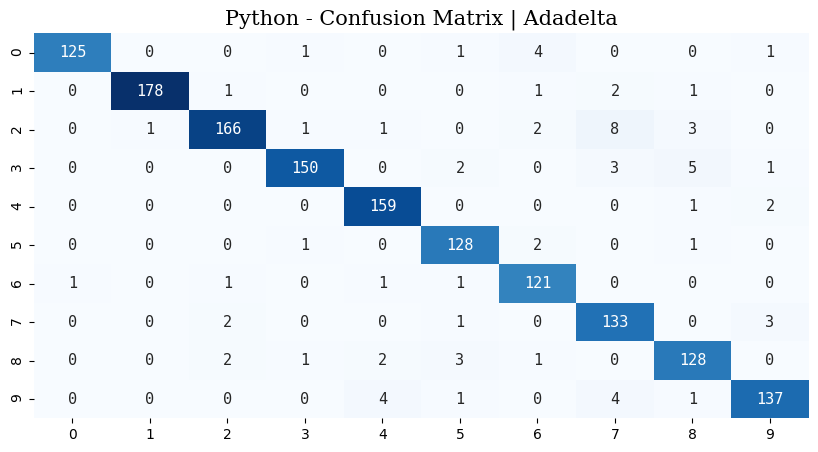

Correct classified: 1,425					Wrong classified: 75
Accuracy: 95.000 %						Error: 5.000 %


In [158]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(preds, y_true)

fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    cm,
    # use specific color
    cmap="Blues",
    # show numbers
    annot=True,
    # format to integer
    fmt="d",
    # don't show colorbar
    cbar=False,
    # format them to look nicer
    annot_kws={"fontsize": 11, "fontfamily": "monospace"},
)
plt.title("Python - Confusion Matrix | Adadelta", size=15, fontfamily="serif")
plt.show()

print(f"Correct classified: {total_correct:,}", end="\t\t\t\t\t")
print(f"Wrong classified: {total_incorrect:,}")
print(f"Accuracy: {acc:.3f} %", end="\t\t\t\t\t\t")
print(f"Error: {error:.3f} %")

![Adadelta Eval Result.jpeg](results/Adadelta-Eval-Result.jpeg)

# Adam

In [54]:
model_adam = create_model()

model_adam.compile(
    ## the book uses Adadelta, but default Adadelta trains too slow
    # optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-8),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    metrics=["accuracy"],
)

history = model_adam.fit(
    ds_train,
    epochs=EPOCHS,
)

Epoch 1/10
50/50 [==============================] - 1s 5ms/step - loss: 0.7419 - accuracy: 0.8151
Epoch 2/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2535 - accuracy: 0.9277
Epoch 3/10
50/50 [==============================] - 0s 5ms/step - loss: 0.1766 - accuracy: 0.9502
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 0.1313 - accuracy: 0.9631
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0999 - accuracy: 0.9727
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0769 - accuracy: 0.9809
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0625 - accuracy: 0.9843
Epoch 8/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0487 - accuracy: 0.9884
Epoch 9/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0405 - accuracy: 0.9908
Epoch 10/10
50/50 [==============================] - 0s 5ms/step - loss: 0.0311 - accuracy: 0.9938


![Adam Train Result.jpeg](results/Adam-Train-Result.jpeg)

In [229]:
(loss, accuracy) = model_adam.evaluate(ds_test)
accuracy

8/8 [==============================] - 0s 4ms/step - loss: 0.1064 - accuracy: 0.9633


0.9633333086967468

In [230]:
model_save_path = os.path.join("models", "python_adam")
tf.saved_model.save(model_adam, model_save_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models\python_adam\assets


In [231]:
model_save_path = os.path.join("models", "python_adam2")
tf.keras.models.save_model(model_adam, model_save_path)

INFO:tensorflow:Assets written to: models\python_adam2\assets


In [240]:
model_adam = tf.keras.models.load_model(os.path.join("models", "python_adam"))

In [241]:
%%time
preds = model_adam.predict(ds_test)
preds.shape

Wall time: 52 ms


(1500, 10)

In [242]:
preds = np.argmax(preds, axis=-1)
preds.shape

(1500,)

In [243]:
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true.shape

(1500, 10)

In [244]:
y_true = np.argmax(y_true, axis=-1)
y_true.shape

(1500,)

In [245]:
total_correct = np.sum(np.where(preds == y_true, 1, 0))
total_incorrect = len(y_true) - total_correct
acc = total_correct / len(y_true) * 100
error = 100 - acc

In [246]:
adam_py = {"Training accuracy": 99.41, "Validation accuracy": acc,
               "Correct classified": total_correct, "Wrong classified": total_incorrect, "Error": error
}
adam_py

{'Training accuracy': 99.41,
 'Validation accuracy': 96.33333333333334,
 'Correct classified': 1445,
 'Wrong classified': 55,
 'Error': 3.666666666666657}

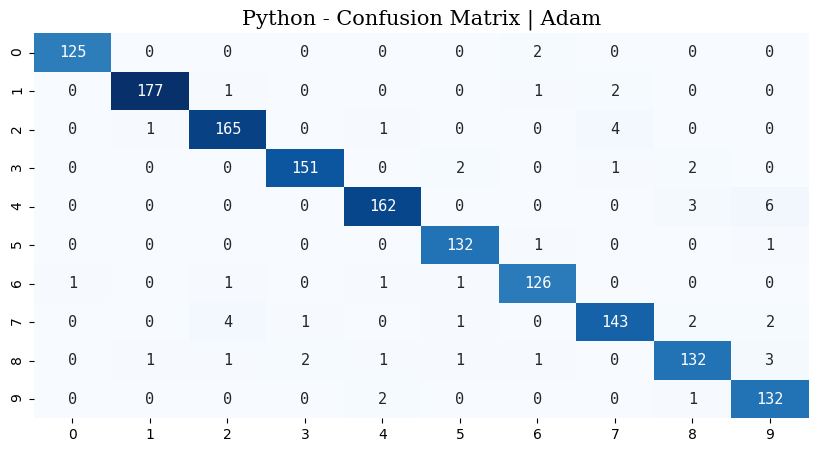

Correct classified: 1,445					Wrong classified: 55
Accuracy: 96.333 %						Error: 3.667 %


In [247]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(preds, y_true)

fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    cm,
    # use specific color
    cmap="Blues",
    # show numbers
    annot=True,
    # format to integer
    fmt="d",
    # don't show colorbar
    cbar=False,
    # format them to look nicer
    annot_kws={"fontsize": 11, "fontfamily": "monospace"},
)
plt.title("Python - Confusion Matrix | Adam", size=15, fontfamily="serif")
plt.show()

print(f"Correct classified: {total_correct:,}", end="\t\t\t\t\t")
print(f"Wrong classified: {total_incorrect:,}")
print(f"Accuracy: {acc:.3f} %", end="\t\t\t\t\t\t")
print(f"Error: {error:.3f} %")

![Adam Eval Result.jpeg](results/Adam-Eval-Result.jpeg)

# Overall comparison

In [248]:
adadelta_py

{'Training accuracy': 97.1,
 'Validation accuracy': 95.0,
 'Correct classified': 1425,
 'Wrong classified': 75,
 'Error': 5.0}

In [249]:
adam_py

{'Training accuracy': 99.41,
 'Validation accuracy': 96.33333333333334,
 'Correct classified': 1445,
 'Wrong classified': 55,
 'Error': 3.666666666666657}

In [250]:
adadelta_knime = {"Training accuracy": 99.50, "Validation accuracy": 93.867,
                  "Correct classified": 1408, "Wrong classified": 92, "Error": 6.133
}
adam_knime = {"Training accuracy": 99.50, "Validation accuracy": 96.533,
               "Correct classified": 1448, "Wrong classified": 52, "Error": 3.467
}

In [251]:
import pandas as pd

df = pd.DataFrame([adadelta_py, adadelta_knime, adam_py, adam_knime], index=['Adadelta Python', 'Adadelta KNIME', 'Adam Python', 'Adam KNIME'])
df

,Training accuracy,Validation accuracy,Correct classified,Wrong classified,Error
Adadelta Python,97.10,95.000000,1425,75,5.000000
Adadelta KNIME,99.50,93.867000,1408,92,6.133000
Adam Python,99.41,96.333333,1445,55,3.666667
Adam KNIME,99.50,96.533000,1448,52,3.467000


In [267]:
style_dict = {"Training accuracy": '{:,.3f} %',
              "Validation accuracy": '{:,.3f} %',
              "Correct classified": '{:,}',
              "Error": '{:,.3f} %'
             }

df.style.background_gradient(cmap='Blues').format(style_dict)

,Training accuracy,Validation accuracy,Correct classified,Wrong classified,Error
Adadelta Python,97.100 %,95.000 %,"1,425",75,5.000 %
Adadelta KNIME,99.500 %,93.867 %,"1,408",92,6.133 %
Adam Python,99.410 %,96.333 %,"1,445",55,3.667 %
Adam KNIME,99.500 %,96.533 %,"1,448",52,3.467 %


In [253]:
df.to_csv("overall_result.csv")

In [258]:
df2 = pd.read_csv("overall_result.csv", index_col=0)
df2

,Training accuracy,Validation accuracy,Correct classified,Wrong classified,Error
Adadelta Python,97.10,95.000000,1425,75,5.000000
Adadelta KNIME,99.50,93.867000,1408,92,6.133000
Adam Python,99.41,96.333333,1445,55,3.666667
Adam KNIME,99.50,96.533000,1448,52,3.467000


# Loading KNIME models

In [85]:
knime_adadelta = tf.saved_model.load(os.path.join("models", "knime_adadelta"))
print(type(knime_adadelta))
knime_adadelta = knime_adadelta.signatures['serve']
print(type(knime_adadelta))

<class 'tensorflow.python.training.tracking.tracking.AutoTrackable'>
<class 'tensorflow.python.eager.wrap_function.WrappedFunction'>


In [86]:
knime_adam = tf.saved_model.load(os.path.join("models", "knime_adam"))
knime_adam = knime_adam.signatures['serve']

In [87]:
def get_ds_data(ds):
    X = []
    y_true = []
    for x, y in ds:
        X.append(x)
        y_true.append(y)
        
    X = np.concatenate(X, axis=0)
    print(X.shape)
    
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # X = X * 255
    print(X.shape)
    
    y_true = np.concatenate(y_true, axis=0)
    print(y_true.shape)
    y_true = np.argmax(y_true, axis=-1)
    print(y_true.shape)
    return X, y_true

X, y_true = get_ds_data(ds_test)

(1500, 28, 28, 1)
(1500, 28, 28, 1)
(1500, 10)
(1500,)


In [88]:
# make one prediction on a single image (need to include batch dimension)
knime_adadelta(X[:1])

{'output_1/Softmax:0': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[6.5707140e-06, 1.9349225e-06, 1.7434885e-04, 1.6300094e-03,
         2.7692574e-06, 5.4596858e-06, 1.8830294e-08, 9.9780792e-01,
         1.6011261e-05, 3.5501589e-04]], dtype=float32)>}

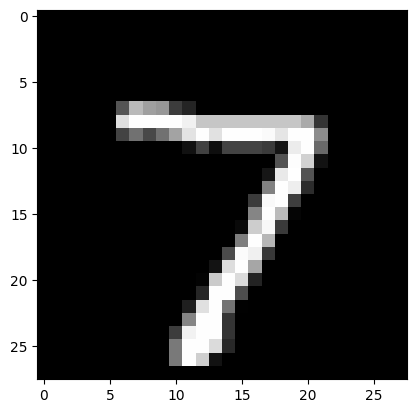

In [89]:
plt.imshow(X[0].numpy(), cmap='gray')
plt.show()

In [100]:
def predict(model, X):
    # make full predictions on multiple images
    preds = model(X)

    y_pred = preds['output_1/Softmax:0']
    y_pred = np.argmax(y_pred.numpy(), axis=-1)
    return y_pred

In [102]:
y_pred = predict(knime_adadelta, X)

total_correct = np.sum(np.where(y_preds == y_true, 1, 0))
total_incorrect = len(y_true) - total_correct
acc = total_correct / len(y_true) * 100
error = 100 - acc
print("Adadelta KNIME:\n")
print(f"Accuracy: {acc:.3f}")
print(f"Total correct: {total_correct}")
print(f"Total incorrect: {total_incorrect}")
print(f"Error: {error:.3f}")

Adadelta KNIME:

Accuracy: 93.867
Total correct: 1408
Total incorrect: 92
Error: 6.133


In [103]:
y_pred = predict(knime_adam, X)

total_correct = np.sum(np.where(y_pred == y_true, 1, 0))
total_incorrect = len(y_true) - total_correct
acc = total_correct / len(y_true) * 100
error = 100 - acc
print("Adam KNIME:\n")
print(f"Accuracy: {acc:.3f}")
print(f"Total correct: {total_correct}")
print(f"Total incorrect: {total_incorrect}")
print(f"Error: {error:.3f}")

Adam KNIME:

Accuracy: 96.533
Total correct: 1448
Total incorrect: 52
Error: 3.467


## Keras H5 format

In [6]:
knime_model = tf.keras.models.load_model(os.path.join("models", "CNN_HandwrittenDigits_Keras.h5"))

In [7]:
knime_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        320       
_________________________________________________________________
maxpooling2d_1 (MaxPooling2D (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               460900    
_________________________________________________________________
output_1 (Dense)             (None, 10)                1010      
Total params: 462,230
Trainable params: 462,230
Non-trainable params: 0
_____________________________________________________

In [24]:
%%time
preds = knime_model.predict(ds_test)
preds.shape

Wall time: 5.35 s


(1500, 10)

In [25]:
preds = np.argmax(preds, axis=-1)
preds.shape

(1500,)

In [26]:
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true.shape

(1500, 10)

In [27]:
y_true = np.argmax(y_true, axis=-1)
y_true.shape

(1500,)

In [28]:
total_correct = np.sum(np.where(preds == y_true, 1, 0))
total_incorrect = len(y_true) - total_correct
acc = total_correct / len(y_true) * 100
error = 100 - acc

In [30]:
total_correct, total_incorrect, acc, error

(1415, 85, 94.33333333333334, 5.666666666666657)